In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_forward = pd.read_csv('simulated_forward.csv')
tickers = list(df_forward.columns[1:])
dates = list(df_forward['Date'])
trading_days = dates[dates.index('3/18/2016'):]

In [3]:
def get_param(date, currency, length):
    d_index = dates.index(date)
    prices = list(df_forward[currency][d_index - length - 1 : d_index])
    returns = np.array([prices[i] / prices[i-1] - 1 for i in range(1,length+1)])
    return np.mean(returns), np.std(returns)

In [4]:
j=0
all_trades = {}
for j in range(len(trading_days)):
    day = trading_days[j]
    if j != len(trading_days) -1:
        next_day = trading_days[j+1]
    else:
        next_day = day
        
    ret, std = [get_param(day, t, 5)[0] for t in tickers], [get_param(day, t, 5)[1] for t in tickers]  
    scores = [(ret[i] - 0.03/252) / std[i] for i in range(len(tickers)) if std[i] != 0]
    ranking = list(np.argsort(scores))
 
    if day.split('/')[0] != next_day.split('/')[0]:
        sel = ['CNY' for _ in range(3)]
        all_trades[day] = sel
        continue
    
    best, snd, worst = ranking[-1], ranking[-2], ranking[0]

    if np.max(ret) < 0:
        sel = ['CNY', 'CNY', tickers[worst]]
    else:
        sel = [tickers[best], tickers[snd], tickers[worst]]
    all_trades[day] = sel
    
    


In [5]:
capital = 10000000
pnl = []
accumulative = [capital]
for i in range(1, len(trading_days)):
    
    date = trading_days[i]
    prev_date = trading_days[i-1]
    selections = all_trades[prev_date]
    prevs, currs = df_forward.iloc[dates.index(prev_date)], df_forward.iloc[dates.index(date)]
    if selections == ['CNY', 'CNY', 'CNY']:
        pnl.append(capital * 0.03/365)
        capital += capital * 0.03/365
        accumulative.append(capital)
        continue
    elif 'CNY' in selections:
        yesterday = [1, 1, prevs[selections[-1]]]
        today = [1+0.03/365, 1+0.03/365, currs[selections[-1]]]
        
    else:
        yesterday = [prevs[selections[0]], prevs[selections[1]], prevs[selections[-1]]]
        today = [currs[selections[0]], currs[selections[1]], currs[selections[-1]]]

    r1 = 0.5 * capital / yesterday[0] * (today[0]-yesterday[0])

    r2 = 0.5 * capital / yesterday[1] * (today[1]-yesterday[1])

    r3 = -capital / yesterday[-1] * (today[-1]-yesterday[-1])
    


    pnl.append(r1+r2+r3)

    capital += (r1+r2+r3)
    accumulative.append(capital)
print(capital)


    
    
    
    

9821524.96280477


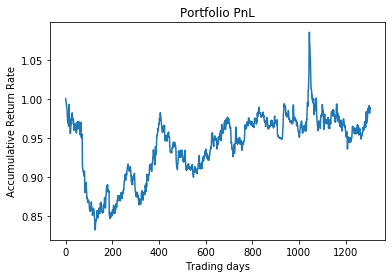

In [6]:
plt.title('Portfolio PnL')
plt.xlabel("Trading days")
plt.ylabel('Accumulative Return Rate')
plt.plot((np.array(accumulative)-1) / accumulative[0])
plt.show()

In [7]:
accumulative = np.array(accumulative)
returns = accumulative[1:] / accumulative[0:len(accumulative) - 1]
returns -= 1
sharpe = (returns.mean()) / np.std(returns) * np.sqrt(365)
sharpe

-0.004486457907566779